In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [13]:
import math

In [4]:
# From Asness et al (2013), Value Momentum Everywhere. Source aqr.com
# pass sector = 'GLOBAL' if you want everything   
def get_aqr_factors(sector,mom=True,val=True,tsmom=True,carry=True):
    aqr=pd.read_csv('AQR_full.csv',parse_dates=['DATE'],index_col=0)
    col=[]
    if sector in ('All', 'GLOBAL'):
        return aqr[['VAL','MOM','TSMOM','CARRY']]
    sec_map={'Equities':'EQ',
             'Commodities':'CO',
             'Currencies':'FX',
             'Fixed Income':'FI',
             'Agriculturals':'CO',
             'Metals':'CO',
             'Energies':'CO'
            }
    if mom:
        col.append('MOM_'+sec_map[sector])
    if val:
        col.append('VAL_'+sec_map[sector])
    if tsmom:
        col.append('TSMOM_'+sec_map[sector])
    if carry:
        col.append('CARRY_'+sec_map[sector])
    return aqr[col]

In [7]:
factors=get_aqr_factors('All')

In [10]:
factors.columns

Index(['VAL', 'MOM', 'TSMOM', 'CARRY'], dtype='object')

In [21]:
(factors[['VAL',  'TSMOM', 'CARRY']]/(factors[['VAL',  'TSMOM', 'CARRY']].std()*math.sqrt(12))*.1).std()*math.sqrt(12)

VAL      0.1
TSMOM    0.1
CARRY    0.1
dtype: float64

In [22]:
rescaled=(factors[['VAL',  'TSMOM', 'CARRY']]/(factors[['VAL',  'TSMOM', 'CARRY']].std()*math.sqrt(12))*.1)

In [27]:
rescaled.dropna().mean(axis=1).std()*math.sqrt(12)

0.04463383760916811

In [28]:
arp=rescaled.dropna().mean(axis=1)

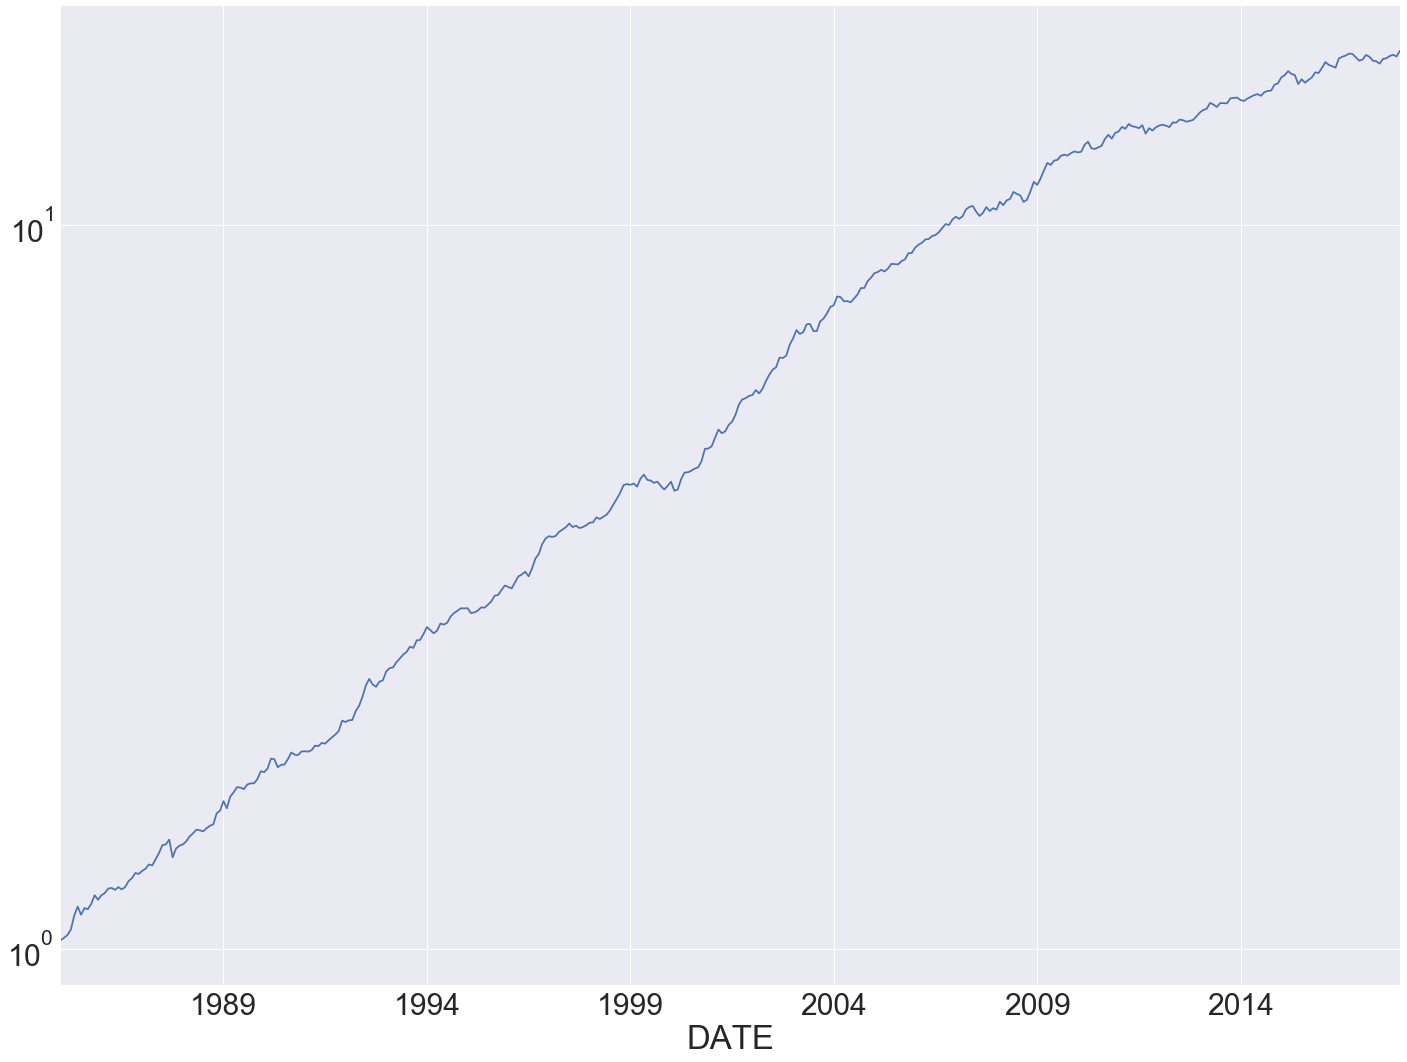

In [31]:
(arp+1).cumprod().plot(logy=True)

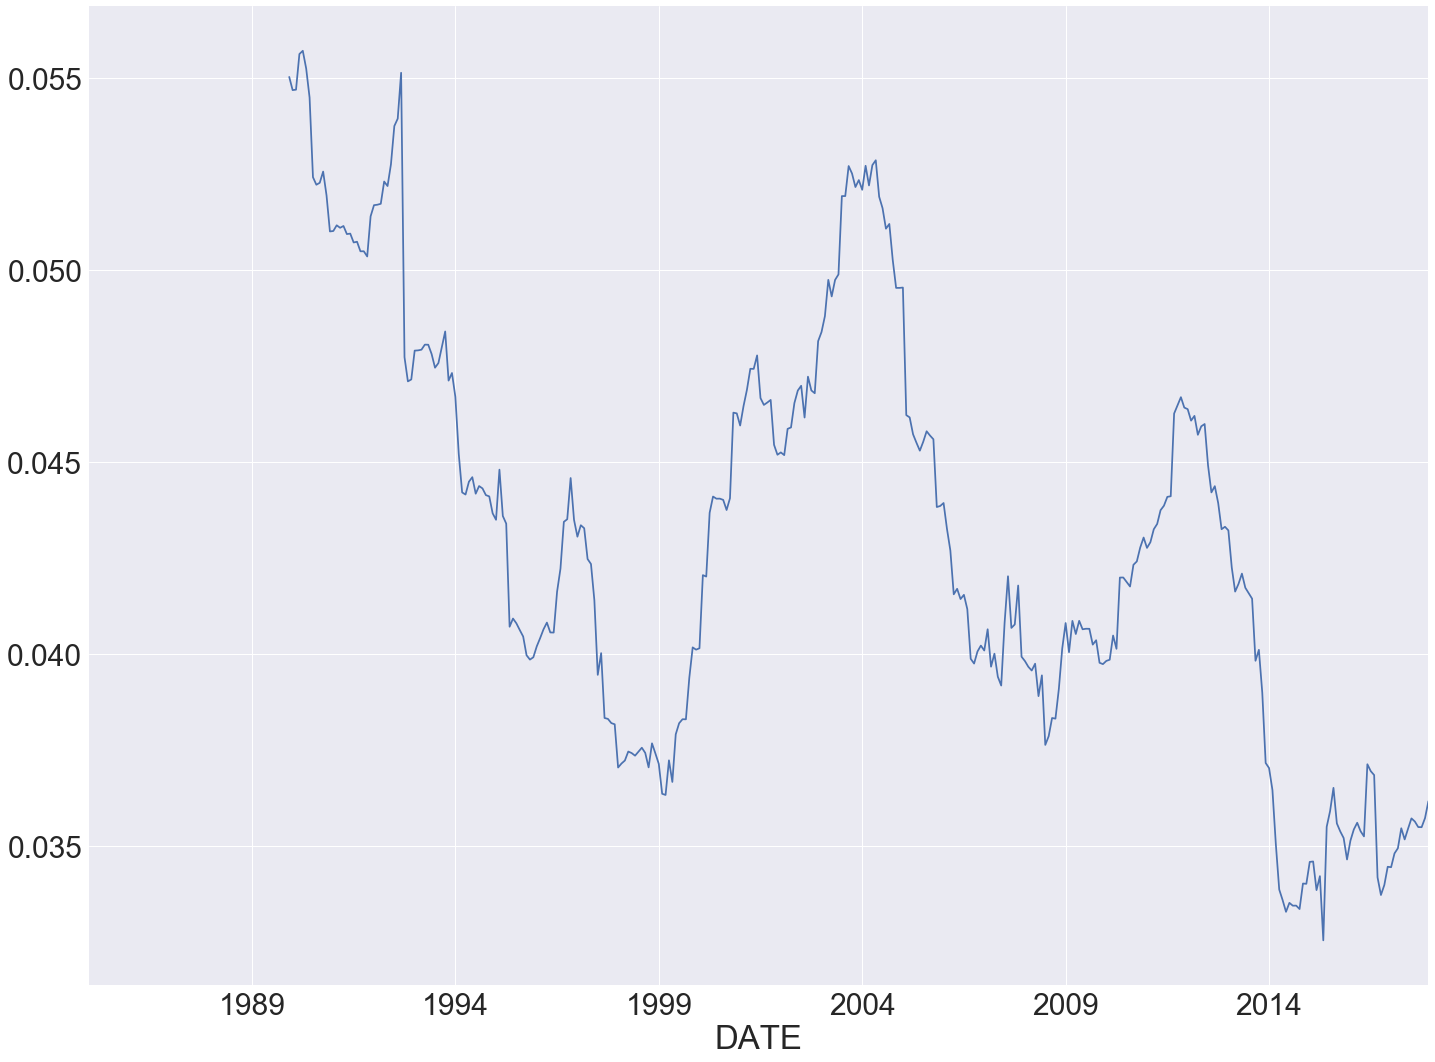

In [33]:
(pd.Series.rolling(arp,60).std()*math.sqrt(12)).plot()

In [34]:
import quandl as q
token="Us3wFmXGgAj_1cUtHAAR"
def calc_risk_parity(vol=.1,lookback=36):
    df=pd.DataFrame()
    df['SP500']=q.get("CHRIS/CME_SP1", authtoken=token).resample(rule='m').last().Last
    df['US10Y']=q.get("CHRIS/CME_US1", authtoken=token).resample(rule='m').last().Last
    data_pct=df.pct_change()
    rtns=((data_pct/pd.DataFrame.ewm(data_pct,lookback,min_periods=lookback/3.).std())*(vol/math.sqrt(12))).dropna()
    mat=pd.DataFrame.ewm(data_pct,lookback,min_periods=lookback/3.).corr().dropna()
    sf=pd.Series()
    for d,dd in mat.groupby(level=0):
        sf[d]=1/math.sqrt(dd.mean().mean())
    return rtns.multiply(sf,axis=0).dropna().mean(axis=1)

In [41]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

In [56]:
yld=q.get("FRED/DGS10", authtoken=token).Value
def yields_to_rtn_index(yld):
    s = pd.Series()
    last=4.06
    for timestamp,yi in yld.iteritems():
        interest = yi/1200.
        np.pv(0.0403,10,4.06,fv=100)
        change=np.pv(yi/100.,10,-last,fv=-100)-100
        last=yi
        s[timestamp]=change+interest
    return s
bd_rtn=yields_to_rtn_index(yld.resample(rule='m').last())

In [65]:
df=pd.DataFrame()
df['RP']=calc_risk_parity()
df['ARP']=arp
df['SP']=q.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken=token).resample(rule='m').last().Value.pct_change()
df['Bonds']=bd_rtn.resample(rule='m').last()/100
w=pd.Series({'SP':0.6,'Bonds':.4})
df['60/40 Portfolio']=df[['SP','Bonds']].multiply(w).sum(axis=1)



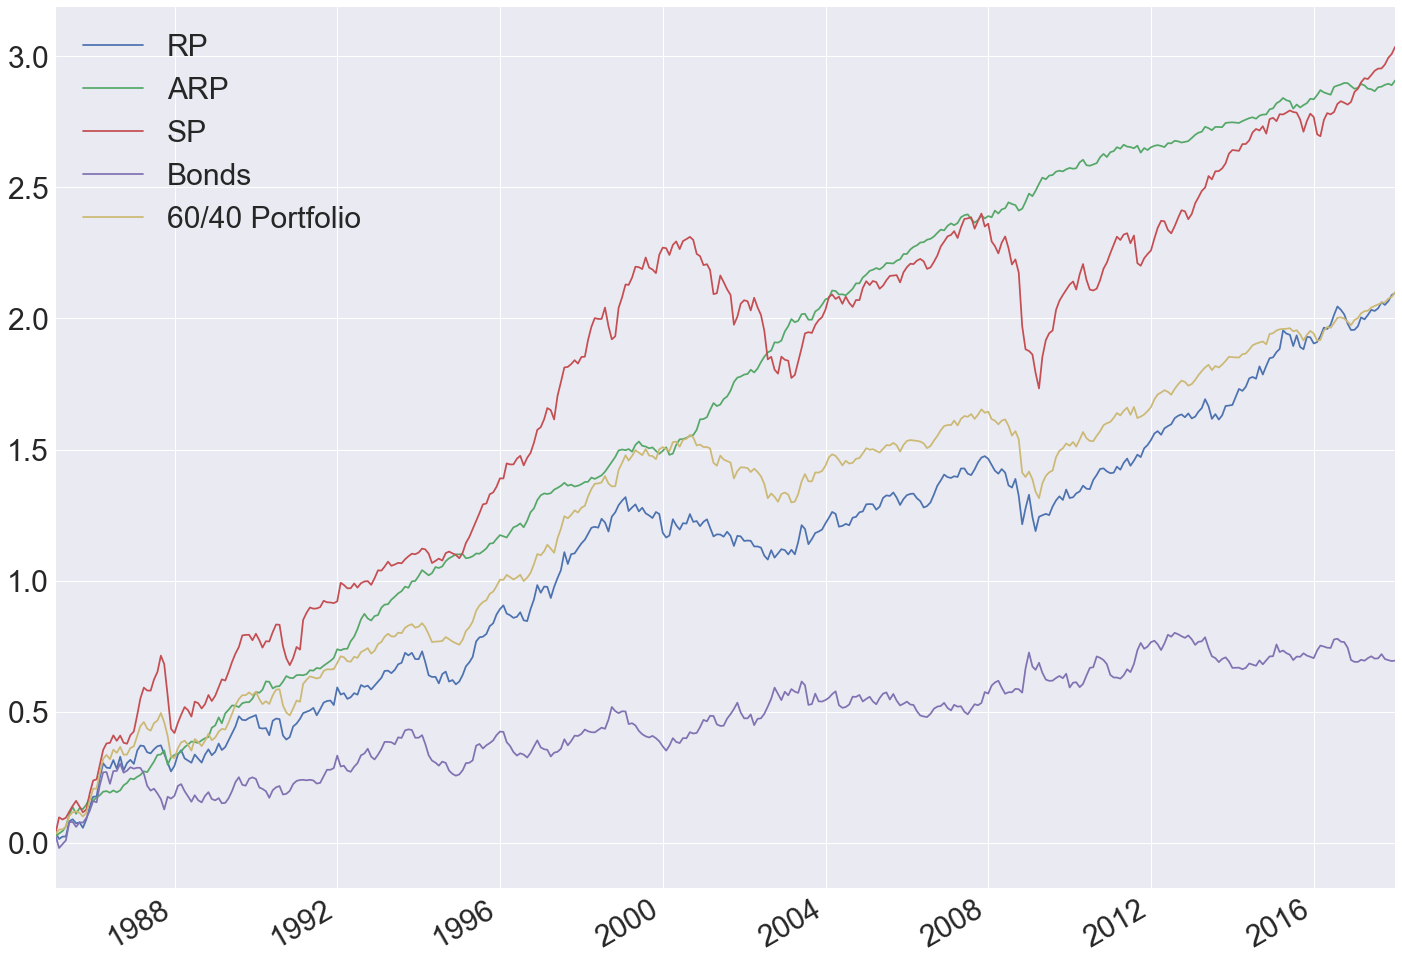

In [72]:
df.dropna().cumsum().plot()

In [75]:
calc_Sharpe(df.dropna()).round(2)

RP                 0.70
ARP                1.98
SP                 0.76
Bonds              0.28
60/40 Portfolio    0.85
dtype: float64

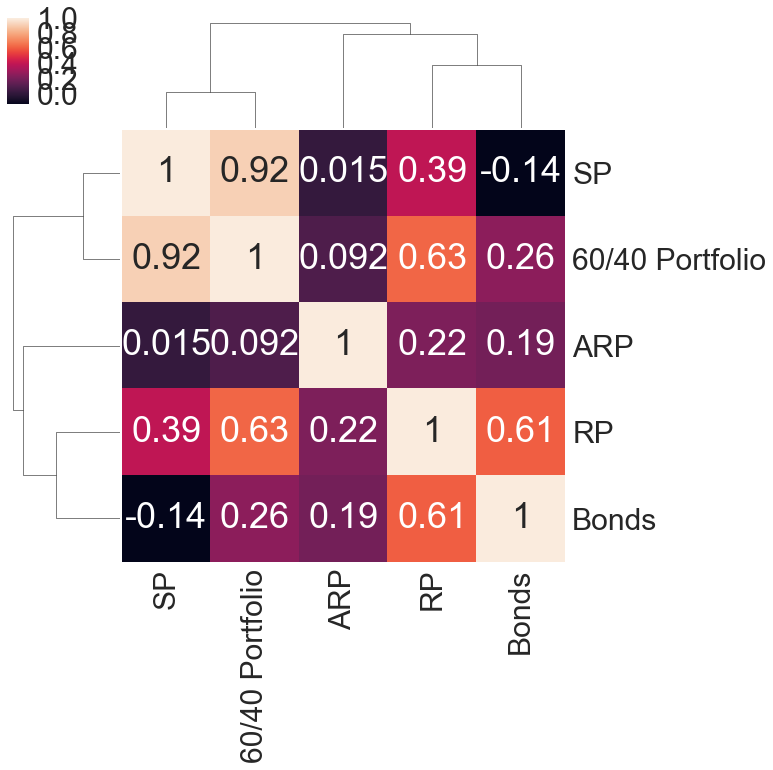

In [74]:
sns.clustermap(df.dropna().corr(),annot=True)

In [77]:
df.dropna().count()/12

RP                 32.916667
ARP                32.916667
SP                 32.916667
Bonds              32.916667
60/40 Portfolio    32.916667
dtype: float64

In [78]:
df.columns

Index(['RP', 'ARP', 'SP', 'Bonds', '60/40 Portfolio'], dtype='object')

[Text(0,0,'1983'),
 Text(0,0,'1984'),
 Text(0,0,'1985'),
 Text(0,0,'1986'),
 Text(0,0,'1987'),
 Text(0,0,'1988'),
 Text(0,0,'1989'),
 Text(0,0,'1990'),
 Text(0,0,'1991'),
 Text(0,0,'1992'),
 Text(0,0,'1993'),
 Text(0,0,'1994'),
 Text(0,0,'1995'),
 Text(0,0,'1996'),
 Text(0,0,'1997'),
 Text(0,0,'1998'),
 Text(0,0,'1999'),
 Text(0,0,'2000'),
 Text(0,0,'2001'),
 Text(0,0,'2002'),
 Text(0,0,'2003'),
 Text(0,0,'2004'),
 Text(0,0,'2005'),
 Text(0,0,'2006'),
 Text(0,0,'2007'),
 Text(0,0,'2008'),
 Text(0,0,'2009'),
 Text(0,0,'2010'),
 Text(0,0,'2011'),
 Text(0,0,'2012'),
 Text(0,0,'2013'),
 Text(0,0,'2014'),
 Text(0,0,'2015')]

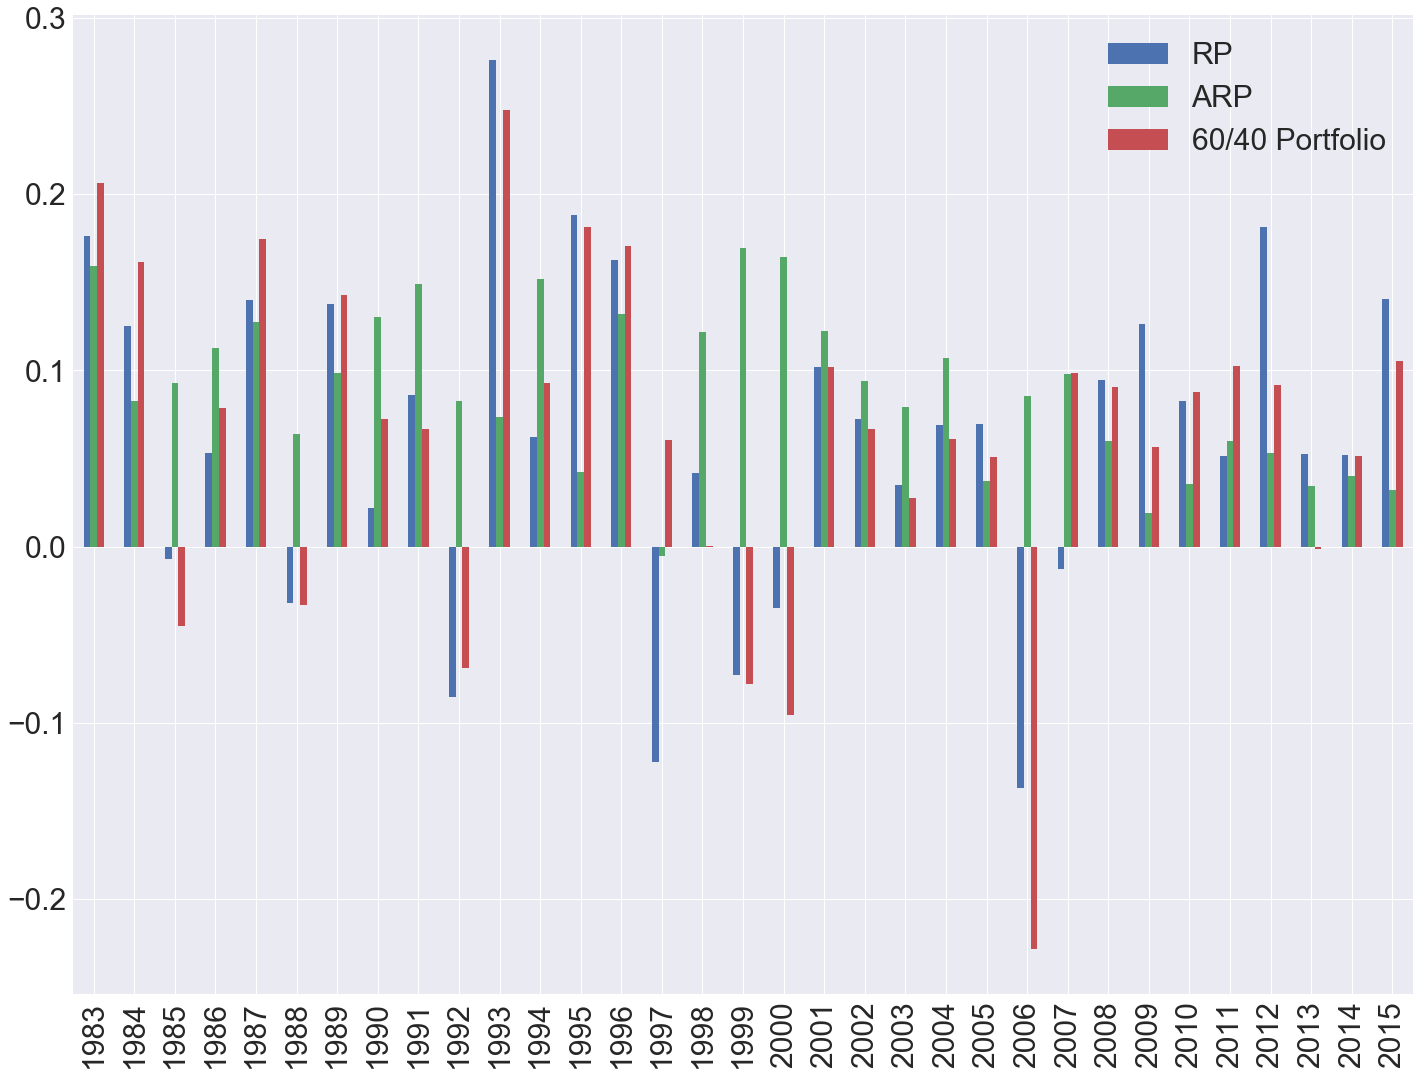

In [109]:
ax=df[['RP', 'ARP','60/40 Portfolio']].dropna().resample(rule='a').sum().plot(kind='bar')
ax.set_xticklabels(df.resample(rule='a').last().index.year)

In [100]:
track=(df[['RP', 'ARP','60/40 Portfolio']].dropna()+1).cumprod()

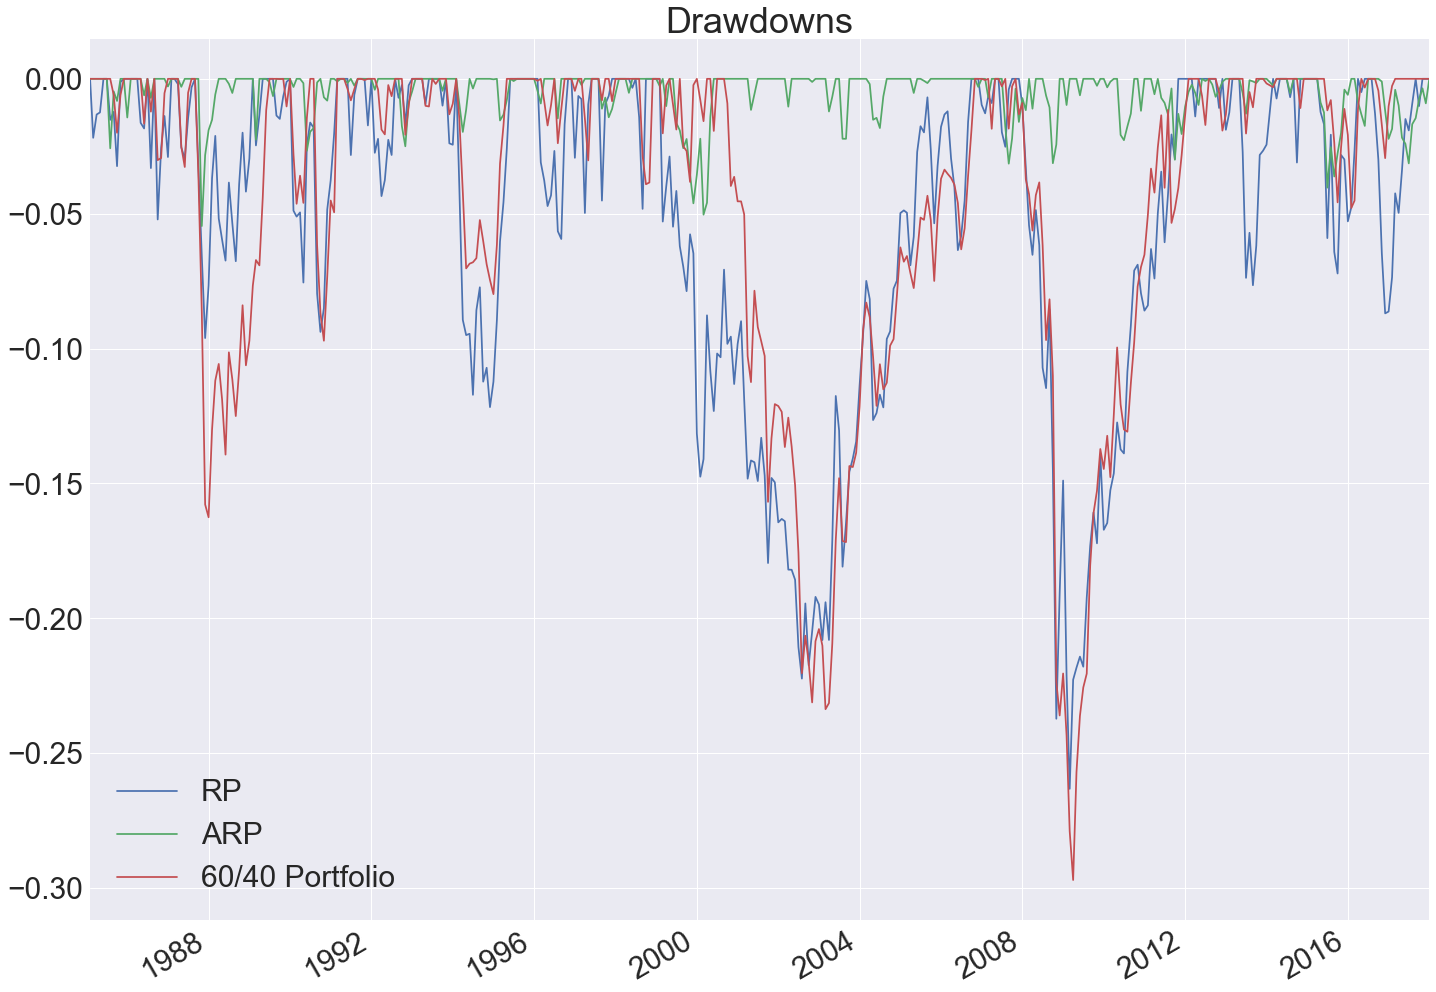

In [108]:
(track/pd.DataFrame.rolling(track,10000,min_periods=1).max()-1).plot(title='Drawdowns')